In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3,padding=0),  # 26
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),  # 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),
            nn.MaxPool2d(2,2), # 12
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=0),  # 10
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),  # 8
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.03),
            # nn.MaxPool2d(2,2),  # 7
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 10, 3),  # 6
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(10, 10, 3),  # 4
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.03)
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(10, 10, 1),  #1
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.gap(x)
        x = self.conv7(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,456
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]           1,450
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

In [4]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader, position = 0, leave = True)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
EPOCHS = 15

for epoch in range(EPOCHS):
    print('EPOCH - ', epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH -  0


Loss=0.16300705075263977 Batch_id=468 Accuracy=91.04: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9852/10000 (98.52%)

EPOCH -  1


Loss=0.06110391393303871 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9866/10000 (98.66%)

EPOCH -  2


Loss=0.03711908310651779 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9911/10000 (99.11%)

EPOCH -  3


Loss=0.0815713182091713 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9909/10000 (99.09%)

EPOCH -  4


Loss=0.021823445335030556 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH -  5


Loss=0.016883591189980507 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.40%)

EPOCH -  6


Loss=0.008715870790183544 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 24.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH -  7


Loss=0.02706187777221203 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

EPOCH -  8


Loss=0.009512311778962612 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9926/10000 (99.26%)

EPOCH -  9


Loss=0.008791723288595676 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9943/10000 (99.43%)

EPOCH -  10


Loss=0.018344562500715256 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH -  11


Loss=0.02928108163177967 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH -  12


Loss=0.006230745930224657 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH -  13


Loss=0.04000595584511757 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH -  14


Loss=0.06852941960096359 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]



Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

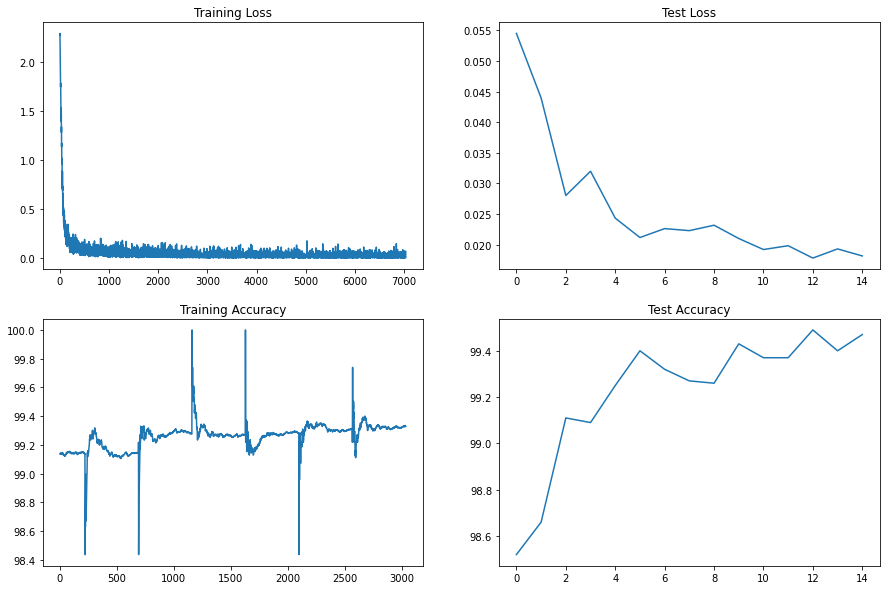

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")